In [1]:
import geopandas as gpd
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os

/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/1k/27mkp8bj3ps60c3nmr7rbqzh0000gn/T/ipykernel_15730/4125638018.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch shou

In [2]:
def merge_csv_files(directory):
    # Get a list of all the csv files
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    # Initialize an empty list to hold dataframes
    dfs = []

    # Loop through csv files, read each into a dataframe, and append to the list
    for file in csv_files:
        # Extract date from filename, assuming the date is in format 'traffic_flow_YYYY_MM_DD'
        date_str = file.split('.')[0].split('_')[-3:]  # This gives ['YYYY', 'MM', 'DD']
        date = datetime.strptime('_'.join(date_str), '%Y_%m_%d').date()

        df = pd.read_csv(os.path.join(directory, file))

        # Add date as a new column
        df['date'] = date.strftime('%m/%d/%y')

        dfs.append(df)

    # Concatenate all dataframes in the list into one dataframe
    merged_df = pd.concat(dfs, ignore_index=True).drop_duplicates()

    # Return the merged dataframe
    return merged_df

In [3]:
traffic_flows = merge_csv_files(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/[XH]Traffic flow')
road_network = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/[XH]road_network/road_network.shp'

# clean the traffic flow data
traffic_flows = traffic_flows.drop_duplicates(['toid', 'date'])
traffic_flows = traffic_flows.groupby(['toid', 'date']).agg(
    {'bus': 'sum', 'car': 'sum', 'cycle': 'sum', 'walks': 'sum', 'stationary': 'sum'}).reset_index()

road_network = gpd.read_file(road_network, crs={'init': 'epsg:27700'})

In [4]:
lsoa = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/London administrative boundaries/london_LSOA/london_LSOA.shp'
road_network = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/[XH]road_network/road_network.shp'
inoutter = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Raw data/London administrative boundaries/lp-consultation-oct-2009-inner-outer-london-shp/lp-consultation-oct-2009-inner-outer-london.shp'
tube_line = 'https://raw.githubusercontent.com/oobrien/vis/master/tubecreature/data/tfl_lines.json'
tube_station = 'https://raw.githubusercontent.com/oobrien/vis/master/tubecreature/data/tfl_stations.json'

inoutter = gpd.read_file(inoutter)
inoutter.to_crs(epsg=27700, inplace=True)

tube_station = gpd.read_file(tube_station)
tube_station.to_crs(epsg=27700, inplace=True)
tube_station = gpd.sjoin(tube_station, inoutter, op='within')

tube_line = gpd.read_file(tube_line)
tube_line.to_crs(epsg=27700, inplace=True)
tube_line = gpd.sjoin(tube_line, inoutter, op='within')

lsoa = gpd.read_file(lsoa, crs={'init': 'epsg:27700'})
road_network = gpd.read_file(road_network, crs={'init': 'epsg:27700'})

/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [5]:
# clean the traffic flow data
traffic_flows = traffic_flows.drop_duplicates(['toid', 'date'])
traffic_flows = traffic_flows.groupby(['toid', 'date']).agg(
    {'bus': 'sum', 'car': 'sum', 'cycle': 'sum', 'walks': 'sum', 'stationary': 'sum'}).reset_index()

In [6]:
flows = pd.merge(
    road_network[['toid', 'roadclassi', 'routehiera', 'geometry',
                  'directiona', 'length', 'roadwidthm', 'elevationg'
                  ]],
    traffic_flows, left_on='toid', right_on='toid', how='right')

# Perform the aggregation to road network level
cycle = traffic_flows.pivot(index='toid', columns='date', values='cycle')

cycle = pd.merge(road_network[['toid', 'roadclassi', 'routehiera', 'geometry',
                               'directiona', 'length', 'roadwidthm', 'elevationg']],
                 cycle,
                 left_on='toid', right_on='toid', how='left').reset_index()
# obtain the date columns
date_columns = cycle.columns[cycle.columns.str.contains('/')]

# Calculate the difference between each date column
for i, col in enumerate(date_columns[1:], 1):
    diff_col_name = f'diff_{col}'
    cycle[diff_col_name] = cycle[date_columns[i]] - cycle[date_columns[i - 1]]

# Calculate the sum and the difference weekly
week_sums = cycle[date_columns].rolling(window=7, axis=1).sum().iloc[:, 6::7]
week_sums.rename(columns={col: f'sum_week_{i}' for i, col in enumerate(week_sums.columns, 1)}, inplace=True)

In [7]:
cycle = pd.concat([cycle, week_sums], axis=1)
cycle['diff_week_1&2'] = cycle['sum_week_2'] - cycle['sum_week_1']
cycle['diff_week_2&3'] = cycle['sum_week_3'] - cycle['sum_week_2']

# re classify the road class
# print(cycle['roadclassi'].unique())
# ['Unknown' 'Not Classified' 'Unclassified' 'B Road' 'A Road' 'Classified Unnumbered' 'Motorway']
# print(cycle['directiona'].unique())
# ['bothDirections' 'inOppositeDirection' 'inDirection']

cycle['classification'] = cycle['roadclassi'].replace(
    {'Unknown': 'Other', 'Not Classified': 'Other', 'Unclassified': 'Other', 'Classified Unnumbered': 'Other'})
cycle.drop(columns=['roadclassi', 'index', 'routehiera'], inplace=True)

In [8]:
flows_gdf = cycle

In [9]:
# 创建一个空的无向图
graph = nx.Graph()

# 遍历 'flows' 数据，添加节点和边
for index, row in flows_gdf.iterrows():
    from_node = row['geometry'].coords[0]  # 路的起点
    to_node = row['geometry'].coords[-1]  # 路的终点
    flow = row['diff_03/01/22']  # Link 的权重，即 Flows
    direction = row['directiona']  # Flow direction

    # Add nodes to the graph
    graph.add_node(from_node, pos=from_node)  # Use 'from_node' as the node position
    graph.add_node(to_node, pos=to_node)  # Use 'to_node' as the node position
    # Add edges to the graph based on the direction
    if direction == 'bothDirections':
        # If the road is bidirectional, flows are split equally in both directions
        graph.add_edge(from_node, to_node, weight=flow / 2,
                       toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
        graph.add_edge(to_node, from_node, weight=flow / 2,
                       toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
    elif direction == 'inOppositeDirection':
        # If the road is in the opposite direction, flows are from the ending point to the starting point
        graph.add_edge(to_node, from_node, weight=flow,
                       toid=row['toid'], classification=row['classification'], geometry=row['geometry'])
    elif direction == 'inDirection':
        # If the road is in the same direction, flows are from the starting point to the ending point
        graph.add_edge(from_node, to_node, weight=flow,
                       toid=row['toid'], classification=row['classification'], geometry=row['geometry'])


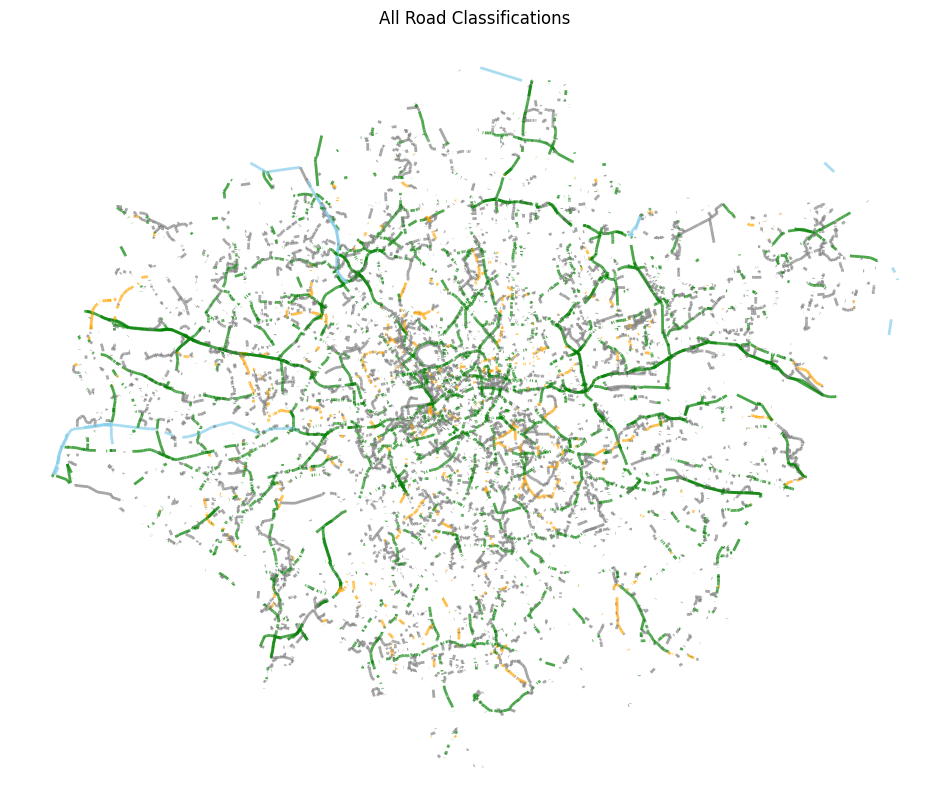

In [ ]:
# Sort edges based on their weight (flow) in descending order
sorted_edges = sorted(graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# Take the top 10% of edges with the highest flow
top_10_edges = sorted_edges[:int(len(sorted_edges) * 0.1)]

# Convert the edge tuples to a list of tuples containing only node names
top_10_edges_nodes = [(u, v) for u, v, _ in top_10_edges]

# Specify the desired 'classification' attribute values to display
desired_classifications = ['Motorway', 'A Road', 'B Road', 'Other']


# Create a subgraph containing all edges
subgraph_all = graph.edge_subgraph(top_10_edges_nodes)

# Get the positions of nodes using the 'pos' attribute for the subgraph containing all edges
node_positions_all = nx.get_node_attributes(subgraph_all, 'pos')

# Add a subplot for the fourth plot to show all road classifications
fig, ax1 = plt.subplots(figsize=(12, 10))

# Loop through all edges in the subgraph containing all edges
for u, v, data in subgraph_all.edges(data=True):
    classification = data['classification']
    # Set different colors based on the 'classification' attribute
    edge_color = 'skyblue' if classification == 'Motorway' else 'green' if classification == 'A Road' else 'orange' if classification == 'B Road' else 'gray'
    # Draw each edge with the corresponding color
    nx.draw_networkx_edges(subgraph_all, pos=node_positions_all, edgelist=[(u, v)], edge_color=edge_color, width=2,
                           alpha=0.7, ax=ax1)

# Set the graph title and axis visibility for the fourth plot
ax1.set_title('All Road Classifications')
ax1.axis('off')
ax1.legend()
# Display the plots
plt.show()

In [ ]:
# Create a new figure and axis for the sub-plots
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=600)

# Loop through each desired classification and plot the corresponding subgraph
for i, desired_classification in enumerate(desired_classifications):
    # Create a subgraph containing only the top 10% edges with the specified 'classification'
    subgraph = graph.edge_subgraph(
        [(u, v) for u, v in top_10_edges_nodes if graph[u][v]['classification'] == desired_classification])

    # Get the positions of nodes using the 'pos' attribute
    node_positions = nx.get_node_attributes(subgraph, 'pos')

    # Add a subplot for each desired classification
    ax2 = axs[i // 2, i % 2]

    # plot the background map
    inoutter.boundary.plot(color='gray', ax=ax2, linewidth=2)

    tube_line['geometry'] = tube_line.geometry.buffer(500)
    tube_line.plot(color='gainsboro', ax=ax2, legend=True)
    tube_station.plot(color='green', ax=ax2, legend=True)

    try:
        # Draw edges
        nx.draw_networkx_edges(subgraph, pos=node_positions, width=2, edge_color='skyblue', ax=ax2)

        # Set the graph title and axis visibility
        ax1.set_title(f'Top 10% Edges with Highest Flow (Classification: {desired_classification})')
        ax1.axis('off')
    except Exception as e:
        print(f"An error occurred for the classification '{desired_classification}': {e}")

# Adjust the layout to avoid overlapping plots
plt.tight_layout()

# Display the plots
plt.show()